# Multi-Layer Perceptron (MLP) for Surname Nationality Classification

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) to classify surnames based on their nationalities using a dataset of surnames and corresponding nationalities.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

## Step 2: Load and Preprocess the Data

The dataset is loaded into a Pandas DataFrame. We need to preprocess this data for our neural network.

In [3]:
# Load the dataset
file_path = 'surnames.csv'
surnames_data = pd.read_csv(file_path)

# Display the first few rows
surnames_data.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


### Data Preprocessing

We need to encode the surnames and nationalities into a numerical format. For surnames, we'll convert each character to its ASCII value. For nationalities, we use label encoding.

In [4]:

# Creating a character set and mapping characters to integers
characters = sorted(list(set(''.join(surnames_data['surname']))))
char_to_int = dict((c, i) for i, c in enumerate(characters))

# Function to convert surname to a sequence of integers
def surname_to_int_array(surname):
    return [char_to_int[char] for char in surname if char in char_to_int]

# Convert surnames to sequences of integers
surnames_data['surname_seq'] = surnames_data['surname'].apply(surname_to_int_array)

# Find the length of the longest surname
max_surname_length = max(surnames_data['surname_seq'].apply(len))

# Pad the sequences so that they are all the same length
from keras.preprocessing.sequence import pad_sequences
surnames_data['surname_padded'] = list(pad_sequences(surnames_data['surname_seq'], maxlen=max_surname_length, padding='post'))

# Convert the padded sequences and labels to numpy arrays for training
X = np.array(surnames_data['surname_padded'].tolist())


In [5]:
# Label encode nationalities
label_encoder = LabelEncoder()
surnames_data['nationality_encoded'] = label_encoder.fit_transform(surnames_data['nationality'])

In [6]:
# One-hot encode the nationality labels
y = to_categorical(surnames_data['nationality_encoded'])

## Step 3: Split the Data

We split the data into training, validation, and test sets.

In [7]:

# Stratified Split of the Data
# We use stratified split to ensure representation of each nationality in all datasets

from sklearn.model_selection import StratifiedShuffleSplit

# Creating a StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Splitting the data - this will only do one split due to n_splits=1
for train_index, temp_index in strat_split.split(X, surnames_data['nationality_encoded']):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Further split X_temp and y_temp into validation and test sets
strat_split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in strat_split_val_test.split(X_temp, y_temp.argmax(axis=1)):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


## Step 4: Build the MLP Model

We build a simple MLP model using Keras.

In [9]:
# Update the MLP model to include an Embedding layer
from keras.layers import Embedding

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(characters), output_dim=50, input_length=max_surname_length))
model.add(Flatten())  # Flatten the output of the embedding layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 50)            4200      
                                                                 
 flatten (Flatten)           (None, 850)               0         
                                                                 
 dense (Dense)               (None, 128)               108928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 18)                1170      
                                                                 
Total params: 122554 (478.73 KB)
Trainable params: 12255

## Step 5: Train the Model

We train the model using the training set and validate it on the validation set.

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
241/241 [==============================] - 3s 7ms/step - loss: 2.0138 - accuracy: 0.4162 - val_loss: 1.6473 - val_accuracy: 0.5355
Epoch 2/50
241/241 [==============================] - 1s 6ms/step - loss: 1.5535 - accuracy: 0.5613 - val_loss: 1.4253 - val_accuracy: 0.5889
Epoch 3/50
241/241 [==============================] - 1s 6ms/step - loss: 1.3701 - accuracy: 0.6088 - val_loss: 1.3030 - val_accuracy: 0.6199
Epoch 4/50
241/241 [==============================] - 1s 6ms/step - loss: 1.2437 - accuracy: 0.6371 - val_loss: 1.2199 - val_accuracy: 0.6485
Epoch 5/50
241/241 [==============================] - 1s 6ms/step - loss: 1.1499 - accuracy: 0.6604 - val_loss: 1.1416 - val_accuracy: 0.6691
Epoch 6/50
241/241 [==============================] - 2s 7ms/step - loss: 1.0762 - accuracy: 0.6828 - val_loss: 1.0785 - val_accuracy: 0.6837
Epoch 7/50
241/241 [==============================] - 2s 9ms/step - loss: 1.0170 - accuracy: 0.7009 - val_loss: 1.0485 - val_accuracy: 0.6897
Epoch 

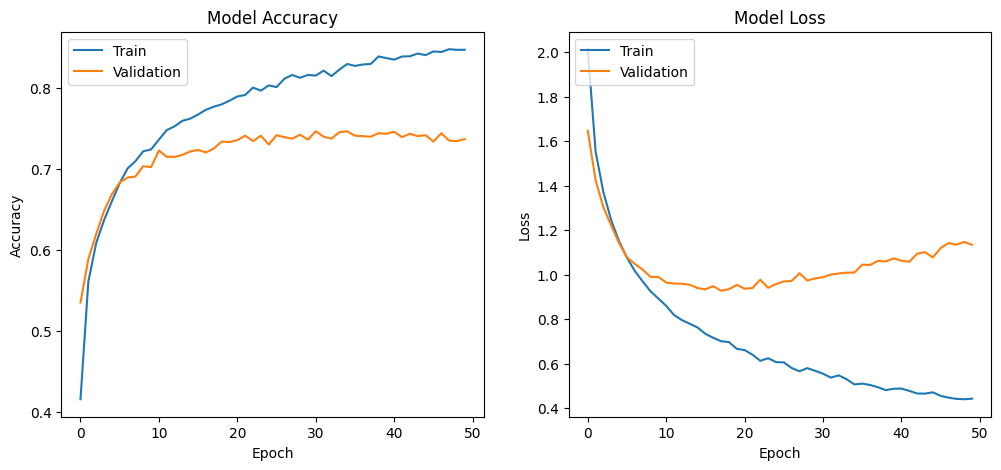

In [11]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Step 6: Evaluate the Model

Evaluate the model's performance on the test set.

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

52/52 [==============================] - 0s 3ms/step - loss: 1.1076 - accuracy: 0.7353
Test Accuracy: 73.53%


## Step 7: Save the Model (Optional)

Optionally, we can save the model for future use.

In [13]:
# Save the model
model.save('surname_nationality_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TODO: Give a surname to the model and ask the model to predict the nationality of it.

TODO: change the architecture of the model to reduce the overfitting

In [15]:
surnames_data['nationality']

0        English
1         French
2        English
3         Arabic
4        Russian
          ...   
10975     Arabic
10976    English
10977     Polish
10978    English
10979     German
Name: nationality, Length: 10980, dtype: object

In [18]:
#Prédiction pour deux noms de familles
max=[surname_to_int_array("Fouche"),surname_to_int_array("Le Goff")]  #4 et 4 sont les index donnant la proba maximale pour Fouche et Le Goff (on commence à 0)
max2=pad_sequences(max, maxlen=max_surname_length, padding='post')
predf=model.predict(max2)
print(predf)
label_encoder.inverse_transform([4]) #5 correspond à l'anglais

1/1 [==============================] - 0s 37ms/step
[[4.26423185e-07 7.57946054e-07 9.39460658e-03 6.59031444e-04
  8.23209822e-01 5.50548658e-02 6.34984672e-02 3.59200116e-04
  7.63516128e-03 7.72518013e-03 1.97091028e-02 2.26286943e-06
  2.91426950e-05 7.91659870e-04 6.95910677e-03 4.53661149e-03
  4.12137917e-04 2.23117295e-05]
 [1.12139014e-06 3.42095471e-12 5.64150140e-03 2.19295453e-05
  5.90764403e-01 2.06188663e-04 2.41497904e-02 1.16441926e-11
  1.63490360e-03 4.54660642e-13 1.69921664e-11 8.00536026e-11
  1.85133786e-07 1.75890888e-12 3.77572507e-01 7.44321369e-06
  7.00831704e-09 1.15480852e-08]]


array(['English'], dtype=object)

In [19]:
#Autre modèle
# Update the MLP model to include an Embedding layer
from keras.layers import Embedding

# Define the model
model2 = Sequential()
model2.add(Embedding(input_dim=len(characters), output_dim=50, input_length=max_surname_length))
model2.add(Flatten())  # Flatten the output of the embedding layer
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.6))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 50)            4200      
                                                                 
 flatten_1 (Flatten)         (None, 850)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               85100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 18)                918       
                                                                 
Total params: 95268 (372.14 KB)
Trainable params: 9526

In [20]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
241/241 [==============================] - 4s 10ms/step - loss: 2.1097 - accuracy: 0.3833 - val_loss: 1.7318 - val_accuracy: 0.5009
Epoch 2/50
241/241 [==============================] - 1s 5ms/step - loss: 1.6551 - accuracy: 0.5346 - val_loss: 1.5229 - val_accuracy: 0.5495
Epoch 3/50
241/241 [==============================] - 1s 5ms/step - loss: 1.4764 - accuracy: 0.5762 - val_loss: 1.3677 - val_accuracy: 0.6011
Epoch 4/50
241/241 [==============================] - 1s 5ms/step - loss: 1.3563 - accuracy: 0.6099 - val_loss: 1.2640 - val_accuracy: 0.6254
Epoch 5/50
241/241 [==============================] - 1s 5ms/step - loss: 1.2771 - accuracy: 0.6300 - val_loss: 1.2302 - val_accuracy: 0.6345
Epoch 6/50
241/241 [==============================] - 1s 5ms/step - loss: 1.2143 - accuracy: 0.6491 - val_loss: 1.1682 - val_accuracy: 0.6503
Epoch 7/50
241/241 [==============================] - 1s 5ms/step - loss: 1.1636 - accuracy: 0.6591 - val_loss: 1.1284 - val_accuracy: 0.6661
Epoch

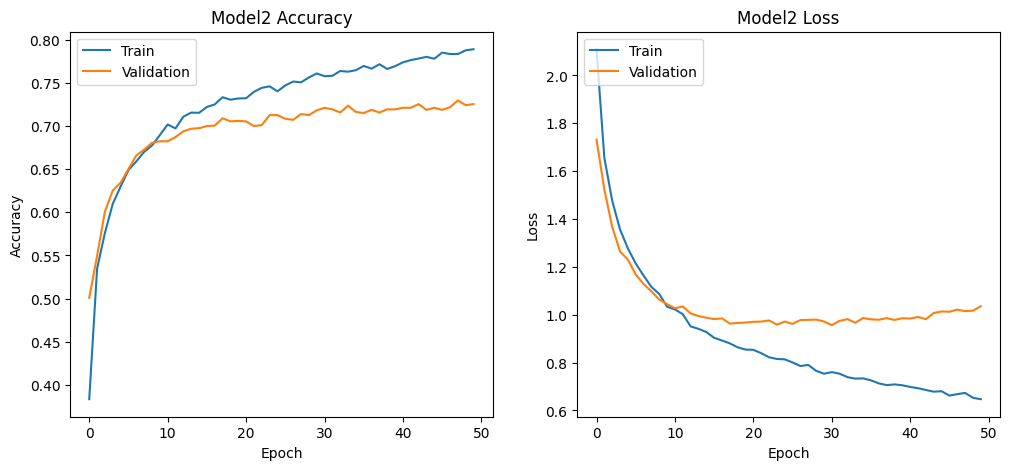

In [21]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [22]:
# Evaluate the model2
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy2*100:.2f}%")

52/52 [==============================] - 0s 2ms/step - loss: 1.0000 - accuracy: 0.7292
Test Accuracy: 72.92%
